In [2]:
%cd ..
%load_ext autoreload
%autoreload 2


/home/teo/userdata/SejongMusic


In [3]:
import torch
from typing import *
from omegaconf import OmegaConf

from sejong_music.constants import  POSITION, PITCH, PART
from sejong_music.jg_code import JeongganDataset, JeongganTokenizer, JeongganPiece
from sejong_music.model_zoo import JeongganTransSeq2seq
from sejong_music.inference import JGInferencer
from sejong_music.jg_to_staff_converter import JGToStaffConverter

config = OmegaConf.load('wandb/run-20240331_162810-ck6676ga/files/checkpoints/config.yaml')
dataset = JeongganDataset(is_valid=True)
tokenizer = JeongganTokenizer(None, None, json_fn='wandb/run-20240401_110925-gfmcjxfa/files/checkpoints/tokenizer_vocab.json')
dataset.tokenizer = tokenizer
model = JeongganTransSeq2seq(tokenizer, config.model)
inferencer = JGInferencer(model, is_condition_shifted=True, is_orch=True, top_p=0.7, temperature=0.9)
converter = JGToStaffConverter()


/home/teo/.local/share/virtualenvs/SejongMusic-0Xd-sAL0/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ConfigAttributeError: Missing key is_pos_enc
    full_key: model.is_pos_enc
    object_type=dict

In [3]:
from sejong_music.jg_to_staff_converter import Note
import numpy as np

piece = dataset.all_pieces[0]
tokens = piece.sliced_parts_by_inst['daegeum'][0]
num_frame_per_jg = 6
features = ['main', 'orn', 'beat_idx', 'jg_idx', 'gak_idx']


notes:List[Note] = JGToStaffConverter.convert_to_notes(piece.sliced_parts_by_inst['daegeum'][0])
JGToStaffConverter.get_duration_of_notes(notes)
num_jgs = sum([1 for x in tokens if x in ('|', '\n')])

outputs = np.zeros((num_jgs * num_frame_per_jg, len(features)), dtype=object)
outputs[:, 2] = np.arange(num_jgs * num_frame_per_jg) % num_frame_per_jg
num_jg_per_gak = JeongganPiece.get_measure_length(tokens)
cur_idx = 0
for i, num_jg in enumerate(num_jg_per_gak):
  outputs[cur_idx:cur_idx+num_jg*num_frame_per_jg, 3] = np.arange(num_jg).repeat(num_frame_per_jg)
  outputs[cur_idx:cur_idx+num_jg*num_frame_per_jg, 4] = i
  cur_idx += num_jg*num_frame_per_jg


for note in notes:
  jg_offset, beat_offset, duration = note.jg_offset, note.beat_offset, note.duration
  if duration is None:
    duration = 0
  start_frame = round((jg_offset + beat_offset) * num_frame_per_jg)
  end_frame = max(round((jg_offset + beat_offset + duration) * num_frame_per_jg), start_frame+1)
  # print(start_frame, end_frame, note)
  outputs[start_frame:end_frame, 0] = note.pitch
  if note.ornaments:
    outputs[start_frame, 1] = note.ornaments[0]
  else:
    outputs[start_frame, 1] = '음표시작'



# for frame in outputs:
#   print(frame[:])

In [241]:
piece = dataset.all_pieces[0]
tokens = piece.sliced_parts_by_inst['daegeum'][0]

notes:List[Note] = JGToStaffConverter.convert_to_notes(tokens)
JGToStaffConverter.get_duration_of_notes(notes)

for note in notes:
  # print(note)
  print(note.pitch, note.ornaments, note.duration, note.beat_offset,note.jg_offset, note.gak_offset)

태 ['나니로'] 1 0 0 0
황 ['니나'] 5/3 0 1 0
니레나 [] 1/3 2/3 2 0
배임 [] 5/3 0 3 0
쉼표 [] 1/3 2/3 4 0
태 ['나니로'] 1 0 0 1
황 ['니나'] 2/3 0 1 1
니나* [] 1/3 2/3 1 1
중 [] 2/3 0 2 1
황 [] 1/3 2/3 2 1
임 ['나니로'] 3/2 0 3 1
니나* [] 1/6 1/2 4 1
중 [] 1/3 2/3 4 1
황 ['노니로'] 2/3 0 5 1
니나* [] 1/3 2/3 5 1
중 [] 1/3 0 6 1
쉼표 [] 1/3 1/3 6 1
중 ['미는표'] 4 2/3 6 1
태 [] 1/3 2/3 10 1
황 ['노니로'] 1/3 0 11 1
중 [] 4/3 1/3 11 1
황 ['노니로'] 1/3 2/3 12 1
임 ['나니로'] 1 0 13 1
임 ['니레'] 2/3 0 14 1
중 [] 1/3 2/3 14 1
황 ['노니로'] 1/2 0 15 1
중 [] 1/6 1/2 15 1
무 ['느니-르'] 1/3 2/3 15 1
중 [] 5/3 0 0 2
니레나 [] 1/3 2/3 1 2
황 ['노니로'] 2/3 0 2 2
쉼표 [] 1/2 2/3 2 2
중 [] 1/3 1/6 3 2
니 [] 1/6 1/2 3 2
무 [] 1/6 2/3 3 2
노 [] 1/6 5/6 3 2
청황 [] 2/3 0 4 2
니나* [] 1/3 2/3 4 2
임 ['노니로'] 1/6 0 5 2
중 [] 1/6 1/6 5 2
무 ['느니-르', '노니로'] 2/3 1/3 5 2
중 [] 1 0 6 2
황 ['노니로'] 2/3 0 7 2
태 ['니레'] 1/3 2/3 7 2
배임 [] 1 0 8 2
배임 ['니나'] 2/3 0 9 2
니나* [] 1/3 2/3 9 2
황 [] 2/3 0 10 2
니나* [] 1/3 2/3 10 2
중 [] 11/6 0 11 2
니나* [] 1/6 5/6 12 2
황 ['노니로'] 2/3 0 13 2
태 ['니레'] 1/3 2/3 13 2
배임 [] 2/3

In [4]:
from sejong_music.jg_code import JGMaskedDataset

dataset = JGMaskedDataset(data_path='music_score/gen_code/')


Converting segments to roll...: 100%|██████████| 77/77 [00:07<00:00, 10.77it/s]


In [5]:
import torch.nn as nn
from sejong_music.model_zoo import Seq2seq
from sejong_music.transformer_module import JeongganTransEncoder
from sejong_music.module import SumEmbeddingSingleVocab


class JeongganBERT(nn.Module):
  def __init__(self, tokenizer, config):
    super().__init__()
    self.vocab_size = len(tokenizer.vocab)
    self.pred_vocab_size = tokenizer.pred_vocab_size
    self.config = config

    self.embedding = SumEmbeddingSingleVocab(self.vocab_size, config.dim)
    self.encoder = JeongganTransEncoder(self.vocab_size, self.config)
    self.proj = nn.Linear(config.dim, self.pred_vocab_size * 2)
    self.pred_vocab_size = self.pred_vocab_size
    
  
  def forward(self, src:torch.Tensor):
    enc_out, _ = self.encoder(src)
    logit = self.proj(enc_out)
    return logit.reshape(logit.shape[0], logit.shape[1], 2, self.pred_vocab_size), None
  
  def _run_inference_on_step(self, final_tokens, encoder_output):
    enc_out, enc_mask = encoder_output['encode_out'], encoder_output['enc_mask']
    kv_cache = encoder_output['kv_cache']
    # logit, _ = self.decoder(final_tokens.unsqueeze(0), enc_out, enc_mask, return_logits=True)
    logit, encoder_output['kv_cache'] = self.decoder(final_tokens.unsqueeze(0), enc_out, enc_mask, return_logits=True, cache=kv_cache)
    return logit[:, -1:], encoder_output, torch.zeros_like(enc_out) # TODO: Return attention weights

  def run_encoder(self, src):
    assert src.ndim == 2
    enc_out, enc_mask = self.encoder(src.unsqueeze(0))
    return {"encode_out": enc_out, "enc_mask": enc_mask, 'kv_cache': None}

config = OmegaConf.load('yamls/bert.yaml')
model = JeongganBERT(tokenizer, config.model)

In [33]:
def nll_loss_bert(pred, target, mask):
  assert pred.shape[:2] == target.shape[:2] == mask.shape[:2]
  pred_flatten = pred.flatten(0, 1)
  target_flatten = target.flatten(0, 1)
  mask_flatten = mask.flatten(0, 1)
  losses = []
  for i in range(2):
    corresp_logit = pred_flatten[:,i][torch.arange(pred_flatten.shape[0]), target_flatten[:,i]]
    loss = -torch.log_softmax(corresp_logit, dim=-1)
    loss = loss * mask_flatten[:,i]
    loss = loss.sum() / mask_flatten[:,i].sum()
    losses.append(loss)
  losses = sum(losses) / 2
  return losses
# loss = nll_loss_bert(pred, target, mask)



In [6]:
from sejong_music.utils import pad_collate_transformer
train_loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn=pad_collate_transformer)

batch = next(iter(train_loader))
src, target, mask = batch
# model.cuda()
# src = src.cuda()
pred = model(src)





In [35]:
from tqdm.auto import tqdm
model = JeongganBERT(tokenizer, config.model)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
model.train()
dev = 'cuda:1'
model.to(dev)

for batch in tqdm(train_loader):
  src, target, mask = batch
  src, target, mask = src.to(dev), target.to(dev), mask.to(dev)
  pred = model(src)
  loss = nll_loss_bert(pred, target, mask)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

100%|██████████| 462/462 [00:41<00:00, 11.01it/s]


In [42]:
pred_class = pred.argmax(dim=-1)
((pred_class == target[...,:2]) * mask).sum() / mask.sum()


tensor(0.5376, device='cuda:1')

In [48]:
from sejong_music.trainer import BertTrainer
from sejong_music.model_zoo import JeongganBERT
model = JeongganBERT(tokenizer, config.model)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

trainer = BertTrainer(model, optimizer, nll_loss_bert, train_loader, train_loader, 'cuda:1', 'wandb/debug/', save_log=False)

In [50]:
trainer.train_by_num_iteration(100)

Acc: 0.0071, Loss: 8.7762: 100%|██████████| 100/100 [00:20<00:00,  4.83it/s]


In [24]:

pred_flatten = pred.flatten(0, 1)
target_flatten = target.flatten(0, 1)
mask_flatten = mask.flatten(0, 1)
print(pred_flatten.shape, target_flatten.shape, mask_flatten.shape)
losses = []
for i in range(2):
  corresp_logit = pred_flatten[:,i][torch.arange(pred_flatten.shape[0]), target_flatten[:,i]]
  loss = -torch.log_softmax(corresp_logit, dim=-1)
  loss = loss * mask_flatten[:,i]
  loss = loss.sum() / mask_flatten[:,i].sum()
  losses.append(loss)
losses = sum(losses) / 2
  

torch.Size([4616, 2, 121]) torch.Size([4616, 6]) torch.Size([4616, 2])


In [8]:
conf_aug.

SyntaxError: invalid syntax (3612134388.py, line 1)

In [22]:
conf.aug

{'entire_orn_r': 0.3, 'jg_r': 0.15, 'frame_replace_r': 0.05, 'frame_rand_r': 0.05, 'mask_note_r': 0.15, 'replace_note_r': 0.05, 'erase_note_r': 0.05}

In [26]:
from sejong_music.jg_code import JGMaskedDataset

conf = OmegaConf.load('yamls/bert.yaml')
dataset = JGMaskedDataset(data_path='music_score/gen_code/', is_valid=True, augment_param=conf.aug)

Converting segments to roll...: 100%|██████████| 6/6 [00:00<00:00, 13.93it/s]


In [12]:
pred_flatten.shape

torch.Size([4616, 2, 121])

In [22]:
pred_flatten[:,0][torch.arange(len(target_flatten)), target_flatten[:,0]]

tensor([ 0.5578, -0.5004, -0.3914,  ...,  0.1251,  0.1925,  0.1806],
       grad_fn=<IndexBackward0>)

torch.Size([4616, 2, 121]) torch.Size([4616, 6]) torch.Size([4616, 2])


In [29]:
pred.shape

torch.Size([4, 1154, 2, 121])

In [25]:
dataset.tokenizer.vocab 

['pad',
 'start',
 'end',
 '하하배임',
 '하배황',
 '하배태',
 '하배중',
 '하배임',
 '하배이',
 '하배남',
 '하배무',
 '배황',
 '배태',
 '배협',
 '배고',
 '배중',
 '배임',
 '배남',
 '배무',
 '배응',
 '황',
 '태',
 '협',
 '고',
 '중',
 '임',
 '이',
 '남',
 '무',
 '청황',
 '청태',
 '청협',
 '청고',
 '청중',
 '청임',
 '청남',
 '청무',
 '중청황',
 '-',
 '같은음표',
 '겹요성표',
 '겹흘림표',
 '끊는표',
 '나느나',
 '나니나',
 '나니로',
 '나니르노니르',
 '낮게',
 '너녜',
 '네로나',
 '네로네',
 '노',
 '노네',
 '노니로',
 '노라',
 '노라느니',
 '노리노',
 '농음표',
 '느나',
 '느나르나니',
 '느니',
 '느니-르',
 '느니라',
 '느로니르',
 '늘임표',
 '니',
 '니나',
 '니나*',
 '니레',
 '니레나',
 '니로',
 '니로나',
 '니루-니',
 '덧길이표',
 '덧길이표/반길이표',
 '떠이어표',
 '로',
 '루러표',
 '리',
 '미는표',
 '반길이표',
 '반길이표/덧길이표',
 '배이',
 '서침표',
 '쉼표',
 '슬기둥1',
 '슬기둥2',
 '슬기둥3',
 '시루표',
 '싸랭',
 '요성표',
 '잉어질표',
 '자출',
 '전성',
 '특강표',
 '풀어내림표',
 '비어있음',
 'mask',
 'daegeum',
 'piri',
 'haegeum',
 'gayageum',
 'geomungo',
 'ajaeng',
 'mask',
 'beat:0',
 'beat:1',
 'beat:2',
 'beat:3',
 'beat:4',
 'beat:5',
 'jg:0',
 'jg:1',
 'jg:2',
 'jg:3',
 'jg:4',
 'jg:5',
 'jg:6',
 'jg:7',
 'jg:8',
 'jg:9',
 '

In [19]:
dataset.unique_pitches, dataset.unique_ornaments

(['-',
  '같은음표',
  '겹요성표',
  '고',
  '남',
  '네로나',
  '노',
  '노라',
  '노라느니',
  '느나',
  '느나르나니',
  '느니',
  '니',
  '니나*',
  '니레나',
  '니로나',
  '로',
  '루러표',
  '리',
  '무',
  '배고',
  '배남',
  '배무',
  '배응',
  '배이',
  '배임',
  '배중',
  '배태',
  '배협',
  '배황',
  '비어있음',
  '쉼표',
  '요성표',
  '이',
  '임',
  '전성',
  '중',
  '중청황',
  '청고',
  '청남',
  '청무',
  '청임',
  '청중',
  '청태',
  '청협',
  '청황',
  '태',
  '하배남',
  '하배무',
  '하배이',
  '하배임',
  '하배중',
  '하배태',
  '하배황',
  '하하배임',
  '협',
  '황'],
 ['겹흘림표',
  '끊는표',
  '나느나',
  '나니나',
  '나니로',
  '나니르노니르',
  '낮게',
  '너녜',
  '네로네',
  '노네',
  '노니로',
  '노리노',
  '농음표',
  '느니-르',
  '느니라',
  '느로니르',
  '늘임표',
  '니나',
  '니레',
  '니로',
  '니루-니',
  '덧길이표',
  '덧길이표/반길이표',
  '떠이어표',
  '루러표',
  '미는표',
  '반길이표',
  '반길이표/덧길이표',
  '비어있음',
  '서침표',
  '슬기둥1',
  '슬기둥2',
  '슬기둥3',
  '시루표',
  '싸랭',
  '잉어질표',
  '자출',
  '전성',
  '특강표',
  '풀어내림표'])

In [5]:
import random
from tqdm.auto import tqdm
from sejong_music.mlm_utils import Augmentor

class JGMaskedDataset(JeongganDataset):
  def __init__(self, data_path='music_score/gen_code', 
               slice_measure_num=4, 
               is_valid=False, 
               jeonggan_valid_set=['남창우조 두거', '여창계면 평거', '취타 길타령', '영산회상 중령산', '평조회상 가락덜이', '관악영산회상 염불도드리'], 
               feature_types=['token', 'ornaments', 'in_jg_position', 'jg_offset', 'gak_offset', 'inst'], 
               position_tokens=POSITION, 
               piece_list: List[JeongganPiece] = None, 
               tokenizer: JeongganTokenizer = None):
    super().__init__(data_path, slice_measure_num, is_valid, False, False, jeonggan_valid_set, feature_types, position_tokens, piece_list, tokenizer)
    self.entire_segments = self.get_entire_segments()
    self.unique_pitches, self.unique_ornaments = self._get_unique_pitch_and_ornaments()
    self.augmentor = Augmentor(self.tokenizer, self.unique_pitches, self.unique_ornaments)

  def _get_unique_pitch_and_ornaments(self):
    unique_pitches = set()
    unique_ornaments = set()
    for seg in self.entire_segments:
      for inst, roll in seg.items():
        pitches = [x[0] for x in roll]
        ornaments = [x[1] for x in roll]
        unique_pitches.update(set(pitches))
        unique_ornaments.update(set(ornaments))
    return sorted(list(unique_pitches)), sorted(list(unique_ornaments))
  
  def _get_tokenizer(self, feature_types, tokenizer:JeongganTokenizer=None):
    if tokenizer:
      self.tokenizer = tokenizer
      self.vocab = tokenizer.vocab
    else:
      unique_token = sorted(list(set([key for piece in self.all_pieces for key in piece.token_counter.keys() ]))) + ['비어있음', 'mask']
      self.tokenizer = JeongganTokenizer(unique_token, feature_types=feature_types, is_roll=True)
      self.vocab = self.tokenizer.vocab
  
  def get_entire_segments(self):
    entire_segments = []
    for piece in tqdm(self.all_pieces, desc='Converting segments to roll...'):
      entire_segments += self._get_roll_by_part(piece.sliced_parts_by_measure)
    return entire_segments
  
  def _get_roll_by_part(self, sliced_parts_by_measure:List[Dict[str, List[str]]]):
    return [{inst: JeongganPiece.convert_tokens_to_roll(tokens, inst) for inst, tokens in meas_data.items()} for meas_data in sliced_parts_by_measure]

  def prepare_special_tokens(self):
    source_start_token = ['start'] * len(self.feature_types)
    source_end_token =  ['end'] * len(self.feature_types)
    return torch.LongTensor(self.tokenizer(source_start_token)), torch.LongTensor(self.tokenizer(source_end_token))

  def get_processed_feature(self, selected_insts: List[str], idx:int):
    start_token, end_token = self.prepare_special_tokens()

    x = dataset.tokenizer([x.tolist() for inst, x in dataset.entire_segments[idx].items() if inst in selected_insts])
    x = torch.LongTensor(x).permute(1,2,0)
    correct_x = x.clone()
    x, loss_mask = self.augmentor(x)

    x = x.permute(2,0,1).flatten(0,1)
    loss_mask = loss_mask.permute(2,0,1).flatten(0,1)
    loss_mask = loss_mask[:,:2]
    correct_x = correct_x.permute(2,0,1).flatten(0,1)
    x = torch.cat([start_token.unsqueeze(0), x, end_token.unsqueeze(0)])
    correct_x = torch.cat([start_token.unsqueeze(0), correct_x, end_token.unsqueeze(0)])
    loss_mask = torch.cat([torch.zeros(1, 2), loss_mask, torch.zeros(1,2)])
    return x, correct_x, loss_mask
  
  def __getitem__(self, idx):
    insts_of_piece = list(self.entire_segments[idx].keys())
    if self.is_valid:
      insts = insts_of_piece
    else:
      insts = random.sample(insts_of_piece, random.randint(1, len(insts_of_piece)))

    
    masked_src, org_src, loss_mask = self.get_processed_feature(insts, idx)          
    return masked_src, org_src, loss_mask


dataset = JGMaskedDataset(data_path='music_score/gen_code/')
dataset[0]

Converting segments to roll...: 100%|██████████| 77/77 [00:07<00:00, 10.72it/s]


(tensor([[  1,   1,   1,   1,   1,   1],
         [102, 114, 123, 129, 149, 116],
         [ 56, 114, 124, 129, 149, 116],
         ...,
         [122, 122, 127, 148, 152, 116],
         [122, 122, 128, 148, 152, 116],
         [  2,   2,   2,   2,   2,   2]]),
 tensor([[  1,   1,   1,   1,   1,   1],
         [102, 114, 123, 129, 149, 116],
         [ 56, 114, 124, 129, 149, 116],
         ...,
         [ 39, 114, 127, 148, 152, 116],
         [ 56, 114, 128, 148, 152, 116],
         [  2,   2,   2,   2,   2,   2]]),
 tensor([[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [1., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 0.],
         [0., 0.],
         [0., 0.],
         [1., 0.],
         [0., 0.],
         [0., 0.],
 

In [63]:
import random


x = dataset.tokenizer([x.tolist() for x in dataset.entire_segments[0].values()])
x = torch.LongTensor(x).permute(1,2,0)
x.shape


torch.Size([480, 6, 5])

In [199]:
import random
class Augmentor:
  def __init__(self, 
               tokenizer, 
               pitch_tokens:List[str], 
               ornament_tokens:List[str],
               entire_orn_r:float = 0.05,
               jg_r:float = 0.15,
               frame_replace_r = 0.05, 
               frame_rand_r = 0.05,
               mask_note_r = 0.15,
               replace_note_r =0.05,
               erase_note_r = 0.05,
               **kwargs):
    self.tokenizer = tokenizer
    self.mask_id = tokenizer.tok2idx['mask']
    self.sus_id = tokenizer.tok2idx['-']
    self.pitch_ids:List[int] = sorted(tokenizer(pitch_tokens))
    self.min_pitch = self.pitch_ids[0]
    self.max_pitch = self.pitch_ids[-1]
    self.ornament_ids:List[int] = sorted(tokenizer(ornament_tokens))
    self.num_beat = sum([1 for x in tokenizer.vocab if 'beat' in x])
    
    self.min_beat = tokenizer.tok2idx['beat:0']
    self.max_beat = tokenizer.tok2idx['beat:5']
    self.min_jg = tokenizer.tok2idx['jg:0']
    self.max_jg = tokenizer.tok2idx['jg:19']
    self.min_gak = tokenizer.tok2idx['gak:0']
    self.max_gak = tokenizer.tok2idx['gak:3']
    
    self.jg_r = jg_r
    self.entire_orn_r = entire_orn_r

    self.frame_mask_r = frame_rand_r
    self.frame_replace_r = frame_replace_r
    self.mask_note_r = mask_note_r
    self.replace_note_r = replace_note_r
    self.note_erase_r = erase_note_r
    self.total_note_r = mask_note_r + replace_note_r + erase_note_r

    
  
  def mask_ornaments(self, x:torch.Tensor, start:int, end:int):
    x[start:end, 1] = self.mask_id
    return x
  
  def mask_entire_ornaments(self, x:torch.Tensor):
    x[:, 1] = self.mask_id
  
  def mask_pitch(self, x:torch.Tensor, start:int, end:int):
    x[start:end, 0] = self.mask_id
    return x
  
  def change_pitch(self, x:torch.Tensor, start:int, end:int):
    random_pitch = random.choice(augmentor.pitch_ids)
    x[start:end, 0] = random_pitch
    return x

  def change_ornament(self, x:torch.Tensor, start:int, end:int):
    random_orn = random.choice(augmentor.ornament_ids)
    x[start:end, 1] = random_orn
    return x
  
  def mask_jeonggan(self, x, loss_mask, n=1):
    num_jg = x.shape[0] // self.num_beat
    num_inst = x.shape[2]
    jg_ids = random.sample(range(num_jg), n)
    inst_ids = [random.randint(0, num_inst+1) for _ in range(n)]
    for jg_id, inst_id in zip(jg_ids, inst_ids):
      start = jg_id * self.num_beat
      end = start + self.num_beat      
      if inst_id >= num_inst:
        x[start:end, 0:2] = self.mask_id
        loss_mask[start:end, 0:2] = 1
      else:
        x[start:end, 0:2, inst_id] = self.mask_id
        loss_mask[start:end, 0:2, inst_id] = 1
    return loss_mask
  
  
  def sample_rand_jg(self, max_jg):
    rand_jg = random.randint(self.min_jg, max_jg)
    rand_gak = random.randint(self.min_gak, self.max_gak)
    return rand_jg, rand_gak
  
  def _make_rand_idx_for_pitch(self, x, rand_r):
    num_frame, _, num_inst = x.shape
    n = int(num_frame * num_inst * rand_r)
    rand_idx = torch.randint(0, num_frame, (n,))
    rand_inst = torch.randint(0, num_inst, (n,))

    rand_pair = (rand_idx, torch.zeros_like(rand_idx), rand_inst)
    return rand_pair

  def _make_rand_idx_for_note(self, x, rand_r):
    frame_ids, inst_ids = torch.where(x[:,0,:] != augmentor.sus_id)
    n = int(len(frame_ids) * rand_r)
    rand_idx = torch.randint(0, len(frame_ids), (n,))
    rand_pair = (frame_ids[rand_idx], torch.zeros_like(rand_idx), inst_ids[rand_idx])
    return rand_pair


  def mask_rand_pitch_frame(self, x:torch.Tensor, loss_mask:torch.Tensor):
    rand_pair = self._make_rand_idx_for_pitch(x, self.frame_mask_r)
    x[rand_pair] = self.mask_id
    loss_mask[rand_pair] = 1
  
  def replace_rand_pitch_frame(self, x, loss_mask):
    rand_pair = self._make_rand_idx_for_pitch(x, self.frame_replace_r)
    rand_pitches = torch.randint(self.min_pitch, self.max_pitch, (len(rand_pair[0]),))
    x[rand_pair] = rand_pitches
    loss_mask[rand_pair] = 1
    
  def mask_erase_replace_note(self, x, loss_mask):
    rand_pair = self._make_rand_idx_for_note(x, self.total_note_r)
    num_masks = int(len(rand_pair[0]) * (self.mask_note_r / self.total_note_r))
    num_replaces = int(len(rand_pair[0]) * (self.replace_note_r / self.total_note_r))
    
    x[rand_pair][:num_masks] = self.mask_id
    x[rand_pair][num_masks:num_masks+num_replaces] = torch.randint(self.min_pitch, self.max_pitch, (num_replaces,))
    x[rand_pair][num_masks+num_replaces:] = self.sus_id
    loss_mask[rand_pair] = 1
    
    
  
  def mask_rand_note(self, x):
    rand_pair = self._make_rand_idx_for_note(x, self.mask_note_r)
    x[rand_pair] = self.mask_id

  def erase_rand_note(self, x):
    rand_pair = self._make_rand_idx_for_note(x, self.note_erase_r)
    x[rand_pair] = self.sus_id
  
  def replace_rand_note_pitch(self, x):
    rand_pair = self._make_rand_idx_for_note(x, self.replace_note_r)
    rand_pitches = torch.randint(0, len(self.pitch_ids), (len(rand_pair[0]),))
    x[rand_pair] = rand_pitches
    

  def __call__(self, x:torch.Tensor):
    assert x.ndim == 3
    loss_mask = torch.zeros_like(x, dtype=torch.long)
    
    num_jg_to_mask = int(x.shape[0] // self.num_beat * self.jg_r)
    self.mask_jeonggan(x, loss_mask, num_jg_to_mask)
    self.mask_rand_pitch_frame(x, loss_mask)
    self.replace_rand_pitch_frame(x, loss_mask)
    self.mask_erase_replace_note(x, loss_mask)
    
    if random.random() < self.entire_orn_r: # 5% chance
      self.mask_entire_ornaments(x)
    
    return x, loss_mask
  
x = dataset.tokenizer([x.tolist() for x in dataset.entire_segments[0].values()])
x = torch.LongTensor(x).permute(1,2,0)
augmentor = Augmentor(dataset.tokenizer, dataset.unique_pitches, dataset.unique_ornaments)
x, loss_mask = augmentor(x)

In [206]:
loss_mask[:, :1].sum() / loss_mask[:, :1].numel()

tensor(0.1704)

In [188]:
start = 0
end = 10

x[start:end, 0:2]

tensor([[[102,  25, 102,  25,  25],
         [114, 103, 114, 114, 103]],

        [[ 56,  56,  56,  56,  56],
         [114, 114, 114, 114, 114]],

        [[ 56,  56,  56,  56,  56],
         [114, 114, 114, 114, 114]],

        [[ 56, 101,  56,  56,  56],
         [114, 114, 114, 114, 114]],

        [[ 56,  56,  56,  56, 122],
         [114, 114, 114, 114, 114]],

        [[ 56,  56,  56,  59,  56],
         [114, 114, 114, 114, 114]],

        [[ 56, 122,  56,  56,  56],
         [114, 114, 114, 114, 114]],

        [[ 56,  56,  56,  56,  56],
         [114, 114, 114, 114, 114]],

        [[ 56,  56,  56,  56,  56],
         [114, 114, 114, 114, 114]],

        [[ 56,  56,  56,  56,  56],
         [114, 114, 114, 114, 114]]])

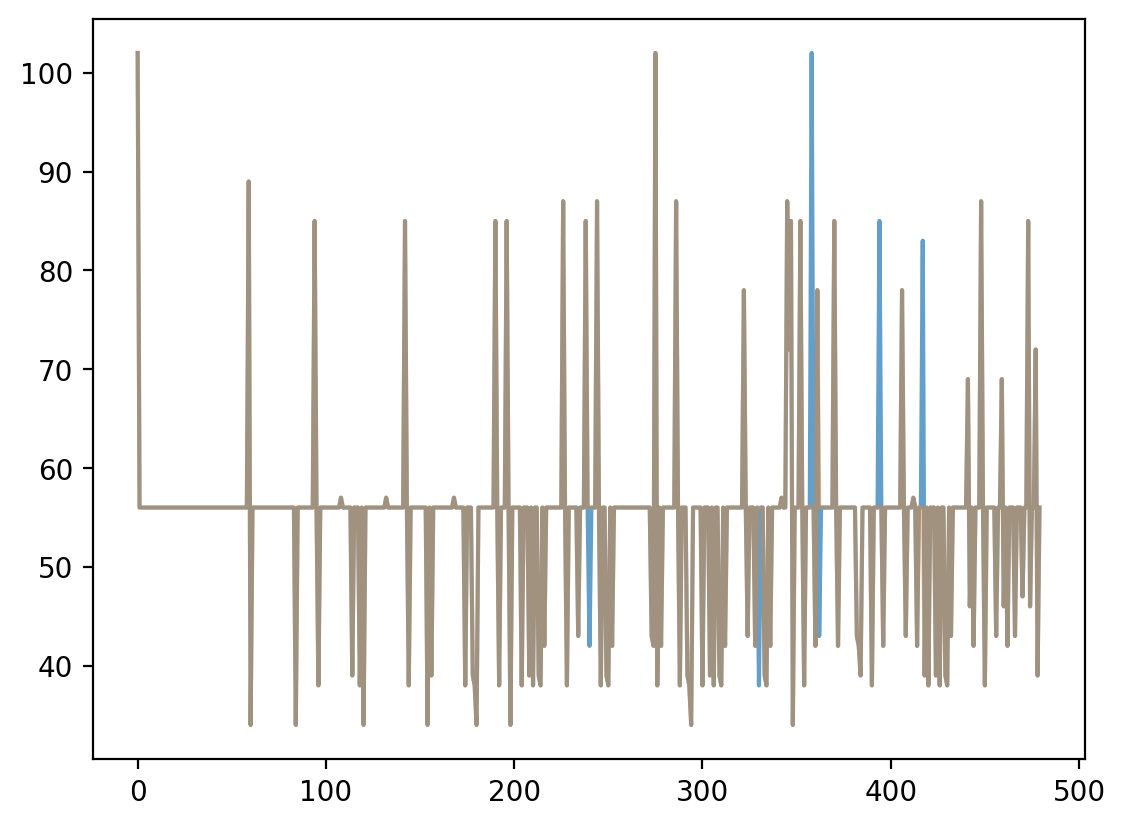

In [181]:
x = dataset.tokenizer([x.tolist() for x in dataset.entire_segments[0].values()])
x = torch.LongTensor(x).permute(1,2,0)
plt.figure()
plt.plot(x[:,0,0], alpha=0.7)
augmentor.erase_rand_note(x)
plt.plot(x[:,0,0], alpha=0.4)

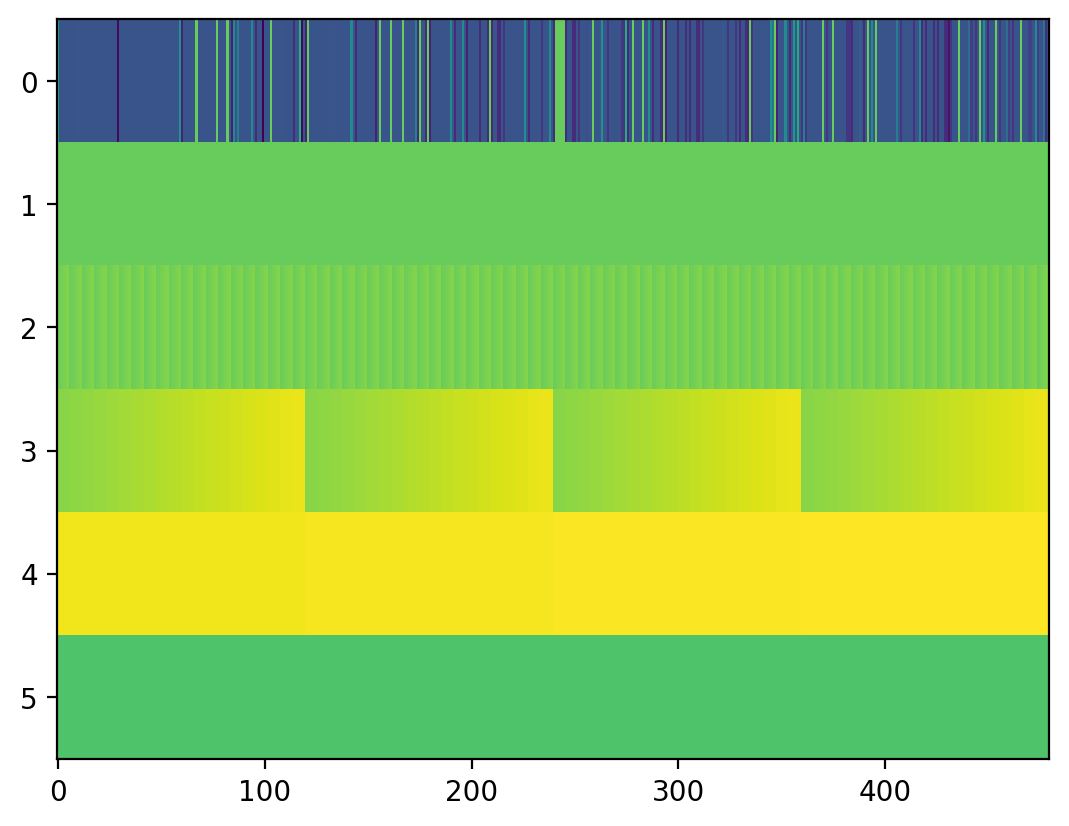

In [157]:
import matplotlib.pyplot as plt
plt.imshow(x[:,:,0].T, aspect='auto', interpolation='none')

In [171]:
import random
random_pitch = random.choice(augmentor.pitch_ids)
random_pitch

72

In [227]:
self = dataset
idx = 0
condition_insts = ['daegeum']
mask_idx = self.tokenizer.tok2idx['mask']


# source_start_token, source_end_token = self.prepare_special_tokens(target_inst)
original_source = [v for v in self.entire_segments[idx].values()]
start_token, end_token = self.prepare_special_tokens()

x = dataset.tokenizer([x.tolist() for x in dataset.entire_segments[idx].values()])
x = torch.LongTensor(x).permute(1,2,0)
correct_x = x.clone()
x, loss_mask = augmentor(x)

x = x.permute(2,0,1).flatten(0,1)
loss_mask = loss_mask.permute(2,0,1).flatten(0,1)
loss_mask = loss_mask[:,:2]
x = torch.cat([start_token.unsqueeze(0), x, end_token.unsqueeze(0)])
loss_mask = torch.cat([torch.zeros(1, 2), loss_mask, torch.zeros(1,2)])
x.shape, loss_mask.shape

# expanded_source = [self.get_inst_and_position_feature(tokens, inst) for inst, tokens in original_source.items()]


# source = [source_start_token] + self.get_inst_and_position_feature(original_source) + [source_end_token]
# random_mask = torch.rand(len(source))

# mask_span_start = torch.randint(0, len(source) - 1)
# mask_span_end = torch.randint(mask_span_start + 1, len(source))

# source[mask_span_start:mask_span_end] = self.tokenizer.mask_token_id

# target = self.get_inst_and_position_feature(original_target, target_inst)
# target = self.shift_condition(target)
# shifted_target = target[1:]
# target = target[:-1]
# shifted_target = [x[0] for x in shifted_target]
# return self.tokenizer(source), self.tokenizer(target), self.tokenizer(shifted_target)


(torch.Size([2402, 6]), torch.Size([2402, 2]))

In [186]:
correct_x[:, :2, :]

tensor([[[102,  25, 102,  25,  25],
         [114, 103, 114, 114, 103]],

        [[ 56,  56,  56,  56,  56],
         [114, 114, 114, 114, 114]],

        [[ 56,  56,  56,  56,  56],
         [114, 114, 114, 114, 114]],

        ...,

        [[ 72,  56,  56,  56,  56],
         [114, 114, 114, 114, 114]],

        [[ 39,  39,  39,  56,  56],
         [114, 114, 114, 114, 114]],

        [[ 56,  56,  56,  56,  56],
         [114, 114, 114, 114, 114]]])

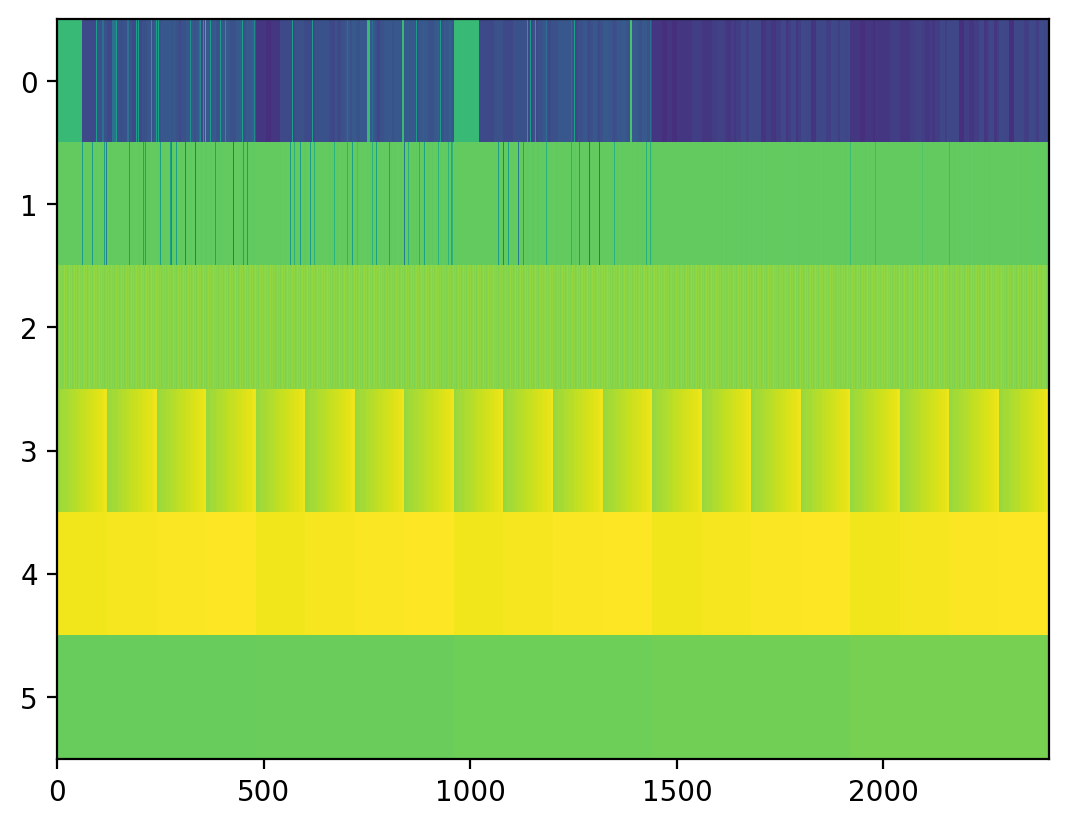

In [153]:
import matplotlib.pyplot as plt

plt.imshow(np.stack(tokenized).T, aspect='auto', interpolation='none')

In [134]:
[f'beat_idx{k}' for k in np.arange(num_jgs * num_frame_per_jg) % num_frame_per_jg]

['beat_idx0',
 'beat_idx1',
 'beat_idx2',
 'beat_idx3',
 'beat_idx4',
 'beat_idx5',
 'beat_idx0',
 'beat_idx1',
 'beat_idx2',
 'beat_idx3',
 'beat_idx4',
 'beat_idx5',
 'beat_idx0',
 'beat_idx1',
 'beat_idx2',
 'beat_idx3',
 'beat_idx4',
 'beat_idx5',
 'beat_idx0',
 'beat_idx1',
 'beat_idx2',
 'beat_idx3',
 'beat_idx4',
 'beat_idx5',
 'beat_idx0',
 'beat_idx1',
 'beat_idx2',
 'beat_idx3',
 'beat_idx4',
 'beat_idx5',
 'beat_idx0',
 'beat_idx1',
 'beat_idx2',
 'beat_idx3',
 'beat_idx4',
 'beat_idx5',
 'beat_idx0',
 'beat_idx1',
 'beat_idx2',
 'beat_idx3',
 'beat_idx4',
 'beat_idx5',
 'beat_idx0',
 'beat_idx1',
 'beat_idx2',
 'beat_idx3',
 'beat_idx4',
 'beat_idx5',
 'beat_idx0',
 'beat_idx1',
 'beat_idx2',
 'beat_idx3',
 'beat_idx4',
 'beat_idx5',
 'beat_idx0',
 'beat_idx1',
 'beat_idx2',
 'beat_idx3',
 'beat_idx4',
 'beat_idx5',
 'beat_idx0',
 'beat_idx1',
 'beat_idx2',
 'beat_idx3',
 'beat_idx4',
 'beat_idx5',
 'beat_idx0',
 'beat_idx1',
 'beat_idx2',
 'beat_idx3',
 'beat_idx4',
 'beat

In [108]:
for line in dataset.entire_segments[1]['daegeum']:
  print(line)

['배임' '노니로' 0 0 0]
['배임' 0 1 0 0]
['배임' 0 2 0 0]
['배임' 0 3 0 0]
['배임' 0 4 0 0]
['배임' 0 5 0 0]
['배임' 0 0 1 0]
['배임' 0 1 1 0]
['배임' 0 2 1 0]
['배임' 0 3 1 0]
['배임' 0 4 1 0]
['배임' 0 5 1 0]
['같은음표' '니나' 0 2 0]
['같은음표' 0 1 2 0]
['같은음표' 0 2 2 0]
['같은음표' 0 3 2 0]
['같은음표' 0 4 2 0]
['같은음표' 0 5 2 0]
['같은음표' 0 0 3 0]
['같은음표' 0 1 3 0]
['같은음표' 0 2 3 0]
['같은음표' 0 3 3 0]
['니나*' '시작' 4 3 0]
['니나*' 0 5 3 0]
['황' '시작' 0 4 0]
['황' 0 1 4 0]
['황' 0 2 4 0]
['황' 0 3 4 0]
['황' 0 4 4 0]
['황' 0 5 4 0]
['황' 0 0 5 0]
['황' 0 1 5 0]
['황' 0 2 5 0]
['황' 0 3 5 0]
['배임' '노니로' 4 5 0]
['배임' 0 5 5 0]
['태' '나니로' 0 6 0]
['태' 0 1 6 0]
['태' 0 2 6 0]
['태' 0 3 6 0]
['태' 0 4 6 0]
['태' 0 5 6 0]
['태' 0 0 7 0]
['태' 0 1 7 0]
['태' 0 2 7 0]
['태' 0 3 7 0]
['태' 0 4 7 0]
['태' 0 5 7 0]
['같은음표' '니레' 0 8 0]
['같은음표' 0 1 8 0]
['같은음표' 0 2 8 0]
['같은음표' 0 3 8 0]
['같은음표' 0 4 8 0]
['같은음표' 0 5 8 0]
['황' '니나' 0 9 0]
['황' 0 1 9 0]
['황' 0 2 9 0]
['황' 0 3 9 0]
['태' '니레' 4 9 0]
['황' '시작' 5 9 0]
['배임' '시작' 0 10 0]
['배임' 0 1 10 0]
['배임' 0 2 10 0]
['배임' 0 3 